# Model Selection

Since the target variable is highly skewed toward the negative class (those who did not subscribe to the term deposit product) different techniques can be used to deal with the imbalance.

* RandomOverSample
* RandomUnderSample
* Variants of SMOTE

Using Pycaret, different techniques can be simulated with different models to obtain a rough, initial metric.

In [1]:
import pandas as pd
import pycaret
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings(action='ignore')

In [2]:
df_ = pd.read_parquet('../Data/dummy-term-deposit-marketing.parquet')
df_.head()

,age,default,balance,housing,loan,day,campaign,y,duration_minutes,job_admin,...,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct
0,58,0,2143,1,0,5,1,0,4.350000,False,...,False,False,False,False,False,False,False,True,False,False
1,44,0,29,1,0,5,1,0,2.516667,False,...,False,False,False,False,False,False,False,True,False,False
2,33,0,2,1,1,5,1,0,1.266667,False,...,False,False,False,False,False,False,False,True,False,False
3,35,0,231,1,0,5,1,0,2.316667,False,...,False,False,False,False,False,False,False,True,False,False
4,28,0,447,1,1,5,1,0,3.616667,False,...,False,False,False,False,False,False,False,True,False,False


In [3]:
df_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38335 entries, 0 to 38334
Data columns (total 40 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  38335 non-null  int8   
 1   default              38335 non-null  int8   
 2   balance              38335 non-null  int32  
 3   housing              38335 non-null  int8   
 4   loan                 38335 non-null  int8   
 5   day                  38335 non-null  int8   
 6   campaign             38335 non-null  int8   
 7   y                    38335 non-null  int8   
 8   duration_minutes     38335 non-null  float64
 9   job_admin            38335 non-null  bool   
 10  job_blue-collar      38335 non-null  bool   
 11  job_entrepreneur     38335 non-null  bool   
 12  job_housemaid        38335 non-null  bool   
 13  job_management       38335 non-null  bool   
 14  job_retired          38335 non-null  bool   
 15  job_self-employed    38335 non-null 

In [4]:
for col in df_.columns:
    if df_[col].dtype == 'bool':
        df_[col] = df_[col].astype('category')

In [5]:
target_variable = df_['y']

X = df_.drop(columns='y', axis=1)

X.head()

,age,default,balance,housing,loan,day,campaign,duration_minutes,job_admin,job_blue-collar,...,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct
0,58,0,2143,1,0,5,1,4.350000,False,False,...,False,False,False,False,False,False,False,True,False,False
1,44,0,29,1,0,5,1,2.516667,False,False,...,False,False,False,False,False,False,False,True,False,False
2,33,0,2,1,1,5,1,1.266667,False,False,...,False,False,False,False,False,False,False,True,False,False
3,35,0,231,1,0,5,1,2.316667,False,False,...,False,False,False,False,False,False,False,True,False,False
4,28,0,447,1,1,5,1,3.616667,False,False,...,False,False,False,False,False,False,False,True,False,False


## Pre-Campaign Modeling

In [6]:
non_demographic_features = [
    'day',
    'campaign',
    'duration_minutes',
    'contact_unknown',
    'contact_telephone',
    'contact_cellular',
    'month_jan',
    'month_feb',
    'month_mar',
    'month_apr',
    'month_may',
    'month_jun',
    'month_jul',
    'month_aug',
    'month_oct',
    'month_nov',
    'month_dec'
]

In [7]:
pre_camp_df = X.iloc[:, ~X.columns.isin(non_demographic_features)]
pre_camp_df.head()

,age,default,balance,housing,loan,job_admin,job_blue-collar,job_entrepreneur,job_housemaid,job_management,...,job_services,job_student,job_technician,job_unemployed,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary
0,58,0,2143,1,0,False,False,False,False,True,...,False,False,False,False,False,True,False,False,False,True
1,44,0,29,1,0,False,False,False,False,False,...,False,False,True,False,False,False,True,False,True,False
2,33,0,2,1,1,False,False,True,False,False,...,False,False,False,False,False,True,False,False,True,False
3,35,0,231,1,0,False,False,False,False,True,...,False,False,False,False,False,True,False,False,False,True
4,28,0,447,1,1,False,False,False,False,True,...,False,False,False,False,False,False,True,False,False,True


In [8]:
cat_features = [col for col in pre_camp_df.columns if pre_camp_df[col].dtype == 'category']
num_features = [col for col in pre_camp_df.columns if pre_camp_df[col].dtype != 'category']
cat_features, num_features

(['job_admin',
  'job_blue-collar',
  'job_entrepreneur',
  'job_housemaid',
  'job_management',
  'job_retired',
  'job_self-employed',
  'job_services',
  'job_student',
  'job_technician',
  'job_unemployed',
  'marital_divorced',
  'marital_married',
  'marital_single',
  'education_primary',
  'education_secondary',
  'education_tertiary'],
 ['age', 'default', 'balance', 'housing', 'loan'])

In [9]:
from pycaret.classification import *
import random

# seed = random.randint(1000, 9999)
seed = 3046

undersample_methods = ['randomundersampler', 'tomeklinks']
overersample_methods = ['randomoversampler', 'smote', 'borderlinesmote']

In [10]:
def run_pycaret(data,
                y,
                categorical_features,
                n_select=5,
                # scoring=None,
                fix_imbalance=False,
                methods=list
                ):
  
  imbalance_type_dict = {}


  for type in methods:
    print(f'Type of imbalance technique: {type}')
    s = setup(data=data,
          target=y, 
          session_id=seed, 
          train_size=.80, 
          fix_imbalance=fix_imbalance, 
          fix_imbalance_method=type,
          categorical_features=categorical_features
        )
    # print(s.X_train)
    print()
    best_models = compare_models(sort='Recall', n_select=n_select)
    results = pull()
    # print(best_models)

    model_score_dict = {}

    for i in range(n_select):
        model_score_dict[results.index[i]] = results.iloc[i].Recall

    imbalance_type_dict[type] = model_score_dict

    print(f"Imbalance type dictionary:\n{imbalance_type_dict}")

    # evaluation = [evaluate_model(estimator=model) for model in best_models]
    print('*'*60)

  return imbalance_type_dict

In [11]:
oversample_type_dict = run_pycaret(pre_camp_df,
                                  target_variable,
                                  cat_features,
                                  5,
                                #   scoring='Recall',
                                  fix_imbalance=True,
                                  methods=overersample_methods)

Type of imbalance technique: randomoversampler


,Description,Value
0,Session id,3046
1,Target,y
2,Target type,Binary
3,Original data shape,"(38335, 23)"
4,Transformed data shape,"(64535, 23)"
5,Transformed train set shape,"(56868, 23)"
6,Transformed test set shape,"(7667, 23)"
7,Numeric features,5
8,Categorical features,17
9,Preprocess,True


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
svm,SVM - Linear Kernel,0.3079,0.5537,0.7889,0.0780,0.1387,0.0108,0.0383,0.3890
lr,Logistic Regression,0.6038,0.6120,0.5560,0.1002,0.1697,0.0528,0.0866,3.2450
ridge,Ridge Classifier,0.6046,0.6120,0.5546,0.1002,0.1697,0.0528,0.0865,0.2360
lda,Linear Discriminant Analysis,0.6047,0.6120,0.5546,0.1002,0.1697,0.0528,0.0865,0.4140
ada,Ada Boost Classifier,0.6275,0.6219,0.5323,0.1028,0.1723,0.0572,0.0897,1.0210
gbc,Gradient Boosting Classifier,0.6498,0.6232,0.5143,0.1064,0.1763,0.0632,0.0951,1.7000
nb,Naive Bayes,0.6158,0.5989,0.5121,0.0968,0.1628,0.0459,0.0728,0.2170
lightgbm,Light Gradient Boosting Machine,0.7127,0.6150,0.4454,0.1161,0.1842,0.0776,0.1037,0.8670
knn,K Neighbors Classifier,0.7967,0.5405,0.2426,0.1064,0.1478,0.0519,0.0577,1.0250
qda,Quadratic Discriminant Analysis,0.8241,0.5621,0.1903,0.1115,0.1294,0.0478,0.0516,0.2300


Imbalance type dictionary:
{'randomoversampler': {'svm': 0.7889, 'lr': 0.556, 'ridge': 0.5546, 'lda': 0.5546, 'ada': 0.5323}}
************************************************************
Type of imbalance technique: smote


,Description,Value
0,Session id,3046
1,Target,y
2,Target type,Binary
3,Original data shape,"(38335, 23)"
4,Transformed data shape,"(64535, 23)"
5,Transformed train set shape,"(56868, 23)"
6,Transformed test set shape,"(7667, 23)"
7,Numeric features,5
8,Categorical features,17
9,Preprocess,True


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
svm,SVM - Linear Kernel,0.3885,0.5435,0.6877,0.0779,0.1343,0.0108,0.0332,0.4930
nb,Naive Bayes,0.5165,0.5852,0.6092,0.0889,0.1551,0.0320,0.0616,0.3730
lr,Logistic Regression,0.6075,0.6111,0.5555,0.1010,0.1709,0.0544,0.0886,1.7110
ridge,Ridge Classifier,0.6080,0.6111,0.5533,0.1008,0.1705,0.0540,0.0879,0.2210
lda,Linear Discriminant Analysis,0.6080,0.6111,0.5529,0.1008,0.1704,0.0538,0.0877,0.1920
qda,Quadratic Discriminant Analysis,0.5917,0.5599,0.4637,0.0893,0.1418,0.0272,0.0392,0.3490
knn,K Neighbors Classifier,0.6530,0.5412,0.3841,0.0847,0.1387,0.0220,0.0321,0.8110
dt,Decision Tree Classifier,0.8717,0.5362,0.1428,0.1363,0.1394,0.0701,0.0702,0.5150
et,Extra Trees Classifier,0.8938,0.5690,0.1056,0.1575,0.1262,0.0721,0.0738,1.7470
rf,Random Forest Classifier,0.9101,0.5852,0.0797,0.2002,0.1135,0.0757,0.0847,1.7660


Imbalance type dictionary:
{'randomoversampler': {'svm': 0.7889, 'lr': 0.556, 'ridge': 0.5546, 'lda': 0.5546, 'ada': 0.5323}, 'smote': {'svm': 0.6877, 'nb': 0.6092, 'lr': 0.5555, 'ridge': 0.5533, 'lda': 0.5529}}
************************************************************
Type of imbalance technique: borderlinesmote


,Description,Value
0,Session id,3046
1,Target,y
2,Target type,Binary
3,Original data shape,"(38335, 23)"
4,Transformed data shape,"(64535, 23)"
5,Transformed train set shape,"(56868, 23)"
6,Transformed test set shape,"(7667, 23)"
7,Numeric features,5
8,Categorical features,17
9,Preprocess,True


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
svm,SVM - Linear Kernel,0.4303,0.5525,0.6613,0.0799,0.1349,0.0152,0.0420,0.4850
nb,Naive Bayes,0.5298,0.5839,0.5963,0.0897,0.1559,0.0335,0.0629,0.3090
lr,Logistic Regression,0.6135,0.6106,0.5479,0.1014,0.1712,0.0550,0.0886,1.9010
ridge,Ridge Classifier,0.6143,0.6105,0.5466,0.1014,0.1711,0.0550,0.0885,0.3100
lda,Linear Discriminant Analysis,0.6143,0.6105,0.5466,0.1014,0.1711,0.0550,0.0884,0.3730
qda,Quadratic Discriminant Analysis,0.5926,0.5568,0.4818,0.0916,0.1473,0.0314,0.0479,0.3530
knn,K Neighbors Classifier,0.7271,0.5427,0.3035,0.0903,0.1392,0.0304,0.0385,0.8500
dt,Decision Tree Classifier,0.8714,0.5444,0.1594,0.1472,0.1528,0.0834,0.0836,0.4040
et,Extra Trees Classifier,0.8943,0.5671,0.1070,0.1605,0.1281,0.0744,0.0762,1.9550
rf,Random Forest Classifier,0.9106,0.5840,0.0783,0.2038,0.1129,0.0757,0.0855,1.7930


Imbalance type dictionary:
{'randomoversampler': {'svm': 0.7889, 'lr': 0.556, 'ridge': 0.5546, 'lda': 0.5546, 'ada': 0.5323}, 'smote': {'svm': 0.6877, 'nb': 0.6092, 'lr': 0.5555, 'ridge': 0.5533, 'lda': 0.5529}, 'borderlinesmote': {'svm': 0.6613, 'nb': 0.5963, 'lr': 0.5479, 'ridge': 0.5466, 'lda': 0.5466}}
************************************************************


In [12]:
oversample_df = pd.DataFrame(oversample_type_dict).T
oversample_df.head()

,svm,lr,ridge,lda,ada,nb
randomoversampler,0.7889,0.5560,0.5546,0.5546,0.5323,NaN
smote,0.6877,0.5555,0.5533,0.5529,NaN,0.6092
borderlinesmote,0.6613,0.5479,0.5466,0.5466,NaN,0.5963


In [13]:
try:
    oversample_df.drop('dummy', axis=1, inplace=True)
except:
    print("'dummy' column not found")

'dummy' column not found


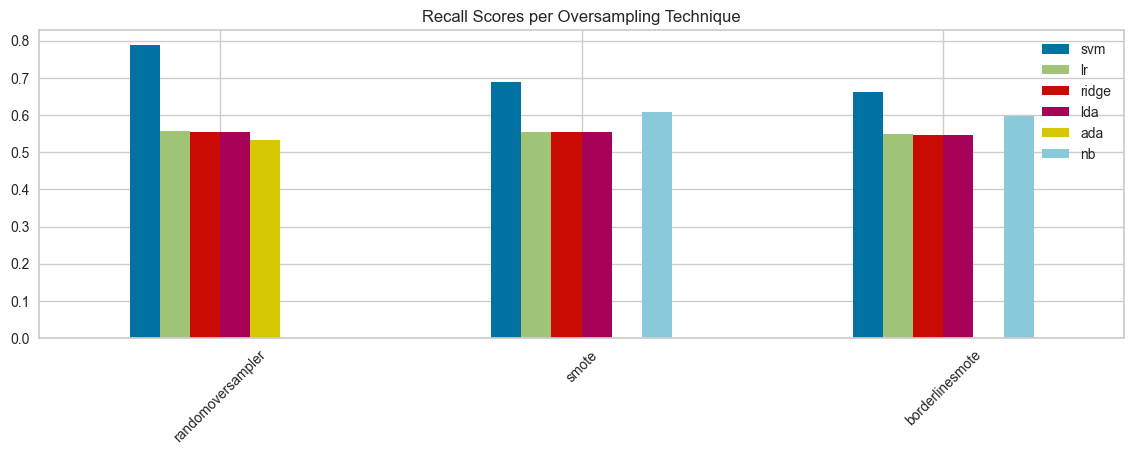

In [14]:
oversample_df.plot(kind='bar', rot=45, legend=True, figsize=(14,4))
plt.title('Recall Scores per Oversampling Technique')
plt.show()

In [15]:
##undersampling Techniques

undersample_type_dict = run_pycaret(pre_camp_df,
                                  target_variable,
                                  cat_features,
                                  5,
                                #   scoring='Recall',
                                  fix_imbalance=True,
                                  methods=undersample_methods)

Type of imbalance technique: randomundersampler


,Description,Value
0,Session id,3046
1,Target,y
2,Target type,Binary
3,Original data shape,"(38335, 23)"
4,Transformed data shape,"(12135, 23)"
5,Transformed train set shape,"(4468, 23)"
6,Transformed test set shape,"(7667, 23)"
7,Numeric features,5
8,Categorical features,17
9,Preprocess,True


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.5894,0.6078,0.5712,0.0988,0.1685,0.0506,0.0853,0.3380
ridge,Ridge Classifier,0.5903,0.6076,0.5699,0.0989,0.1685,0.0506,0.0852,0.1700
lda,Linear Discriminant Analysis,0.5904,0.6075,0.5690,0.0988,0.1683,0.0504,0.0848,0.1760
dt,Decision Tree Classifier,0.5407,0.5502,0.5626,0.0875,0.1515,0.0291,0.0529,0.1740
et,Extra Trees Classifier,0.5586,0.5789,0.5550,0.0900,0.1549,0.0338,0.0596,0.3340
gbc,Gradient Boosting Classifier,0.6081,0.6195,0.5528,0.1008,0.1705,0.0539,0.0877,0.3140
rf,Random Forest Classifier,0.5700,0.5946,0.5519,0.0919,0.1576,0.0373,0.0646,0.3270
lightgbm,Light Gradient Boosting Machine,0.5885,0.5982,0.5483,0.0954,0.1625,0.0439,0.0738,0.6230
ada,Ada Boost Classifier,0.6100,0.6194,0.5430,0.0999,0.1687,0.0521,0.0841,0.2120
nb,Naive Bayes,0.6048,0.5932,0.5354,0.0974,0.1647,0.0473,0.0772,0.1650


Imbalance type dictionary:
{'randomundersampler': {'lr': 0.5712, 'ridge': 0.5699, 'lda': 0.569, 'dt': 0.5626, 'et': 0.555}}
************************************************************
Type of imbalance technique: tomeklinks


,Description,Value
0,Session id,3046
1,Target,y
2,Target type,Binary
3,Original data shape,"(38335, 23)"
4,Transformed data shape,"(37433, 23)"
5,Transformed train set shape,"(29766, 23)"
6,Transformed test set shape,"(7667, 23)"
7,Numeric features,5
8,Categorical features,17
9,Preprocess,True


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
qda,Quadratic Discriminant Analysis,0.5075,0.5593,0.5662,0.0829,0.1425,0.0195,0.0374,1.4210
dt,Decision Tree Classifier,0.8651,0.5342,0.1482,0.1290,0.1379,0.0651,0.0653,1.3880
svm,SVM - Linear Kernel,0.8253,0.4665,0.1327,0.0668,0.0557,-0.0005,0.0035,1.4530
et,Extra Trees Classifier,0.8937,0.5733,0.1142,0.1664,0.1352,0.0807,0.0824,2.0170
nb,Naive Bayes,0.8879,0.5987,0.0953,0.1300,0.1094,0.0515,0.0523,1.4890
rf,Random Forest Classifier,0.9136,0.5862,0.0801,0.2282,0.1184,0.0841,0.0970,1.9820
ada,Ada Boost Classifier,0.9265,0.6230,0.0201,0.4062,0.0383,0.0317,0.0771,1.8300
lightgbm,Light Gradient Boosting Machine,0.9269,0.6192,0.0188,0.4610,0.0360,0.0304,0.0800,1.8360
gbc,Gradient Boosting Classifier,0.9268,0.6246,0.0170,0.4651,0.0327,0.0275,0.0767,2.0580
knn,K Neighbors Classifier,0.9217,0.5341,0.0157,0.1485,0.0283,0.0146,0.0255,2.6970


Imbalance type dictionary:
{'randomundersampler': {'lr': 0.5712, 'ridge': 0.5699, 'lda': 0.569, 'dt': 0.5626, 'et': 0.555}, 'tomeklinks': {'qda': 0.5662, 'dt': 0.1482, 'svm': 0.1327, 'et': 0.1142, 'nb': 0.0953}}
************************************************************


In [16]:
undersample_df = pd.DataFrame(undersample_type_dict).T
undersample_df.head()

,lr,ridge,lda,dt,et,qda,svm,nb
randomundersampler,0.5712,0.5699,0.569,0.5626,0.5550,NaN,NaN,NaN
tomeklinks,NaN,NaN,NaN,0.1482,0.1142,0.5662,0.1327,0.0953


In [17]:
try:
    undersample_df.drop('dummy', axis=1, inplace=True)
except:
    print("'dummy' column not found")

'dummy' column not found


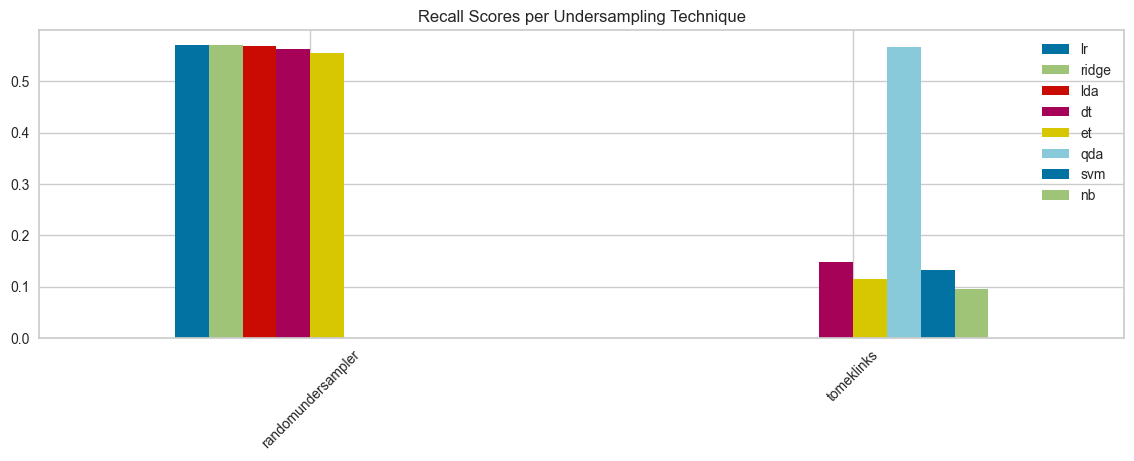

In [19]:
undersample_df.plot(kind='bar', rot=45, legend=True, figsize=(14,4))
plt.title('Recall Scores per Undersampling Technique')
plt.show()

In [20]:
### mix of techniques

mix_type_dict = run_pycaret(pre_camp_df,
                                  target_variable,
                                  cat_features,
                                  5,
                                #   scoring='Recall',
                                  fix_imbalance=True,
                                  methods=['smoteenn', 'smotetomek'])

Type of imbalance technique: smoteenn


,Description,Value
0,Session id,3046
1,Target,y
2,Target type,Binary
3,Original data shape,"(38335, 23)"
4,Transformed data shape,"(45187, 23)"
5,Transformed train set shape,"(37520, 23)"
6,Transformed test set shape,"(7667, 23)"
7,Numeric features,5
8,Categorical features,17
9,Preprocess,True


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dummy,Dummy Classifier,0.0728,0.5000,1.0000,0.0728,0.1358,0.0000,0.0000,4.9490
ridge,Ridge Classifier,0.3358,0.6076,0.8187,0.0839,0.1522,0.0231,0.0669,7.4210
lr,Logistic Regression,0.3405,0.6077,0.8134,0.0840,0.1523,0.0233,0.0666,8.1040
lda,Linear Discriminant Analysis,0.3415,0.6076,0.8116,0.0840,0.1522,0.0232,0.0662,5.1030
nb,Naive Bayes,0.4423,0.5753,0.6692,0.0837,0.1488,0.0222,0.0494,5.2480
qda,Quadratic Discriminant Analysis,0.5792,0.5651,0.5122,0.0893,0.1511,0.0315,0.0521,4.8160
knn,K Neighbors Classifier,0.5532,0.5377,0.5036,0.0820,0.1410,0.0180,0.0317,7.1030
svm,SVM - Linear Kernel,0.5661,0.5076,0.4390,0.0710,0.1125,-0.0016,0.0097,8.3830
dt,Decision Tree Classifier,0.8135,0.5373,0.2139,0.1075,0.1431,0.0511,0.0550,5.7040
et,Extra Trees Classifier,0.8636,0.5789,0.1616,0.1357,0.1474,0.0740,0.0743,5.3200


Imbalance type dictionary:
{'smoteenn': {'dummy': 1.0, 'ridge': 0.8187, 'lr': 0.8134, 'lda': 0.8116, 'nb': 0.6692}}
************************************************************
Type of imbalance technique: smotetomek


,Description,Value
0,Session id,3046
1,Target,y
2,Target type,Binary
3,Original data shape,"(38335, 23)"
4,Transformed data shape,"(62707, 23)"
5,Transformed train set shape,"(55040, 23)"
6,Transformed test set shape,"(7667, 23)"
7,Numeric features,5
8,Categorical features,17
9,Preprocess,True


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
nb,Naive Bayes,0.5177,0.5844,0.6079,0.0889,0.1552,0.0321,0.0616,4.4230
lr,Logistic Regression,0.6077,0.6111,0.5555,0.1011,0.1710,0.0544,0.0887,6.6220
ridge,Ridge Classifier,0.6086,0.6109,0.5551,0.1012,0.1712,0.0547,0.0891,4.2860
lda,Linear Discriminant Analysis,0.6086,0.6109,0.5551,0.1012,0.1712,0.0547,0.0891,4.4150
qda,Quadratic Discriminant Analysis,0.5609,0.5592,0.5209,0.0868,0.1475,0.0268,0.0455,4.3170
svm,SVM - Linear Kernel,0.5371,0.5239,0.5070,0.0777,0.1203,0.0097,0.0267,4.5090
knn,K Neighbors Classifier,0.6529,0.5402,0.3836,0.0845,0.1385,0.0218,0.0318,4.9010
dt,Decision Tree Classifier,0.8675,0.5352,0.1464,0.1318,0.1386,0.0671,0.0672,4.5740
et,Extra Trees Classifier,0.8931,0.5736,0.1124,0.1618,0.1323,0.0775,0.0791,5.6000
rf,Random Forest Classifier,0.9088,0.5849,0.0851,0.2000,0.1190,0.0794,0.0875,5.7350


Imbalance type dictionary:
{'smoteenn': {'dummy': 1.0, 'ridge': 0.8187, 'lr': 0.8134, 'lda': 0.8116, 'nb': 0.6692}, 'smotetomek': {'nb': 0.6079, 'lr': 0.5555, 'ridge': 0.5551, 'lda': 0.5551, 'qda': 0.5209}}
************************************************************


In [21]:
mix_df = pd.DataFrame(mix_type_dict).T
mix_df.head()

,dummy,ridge,lr,lda,nb,qda
smoteenn,1.0,0.8187,0.8134,0.8116,0.6692,NaN
smotetomek,NaN,0.5551,0.5555,0.5551,0.6079,0.5209


In [22]:
try:
    mix_df.drop('dummy', axis=1, inplace=True)
except:
    print("'dummy' column not found")

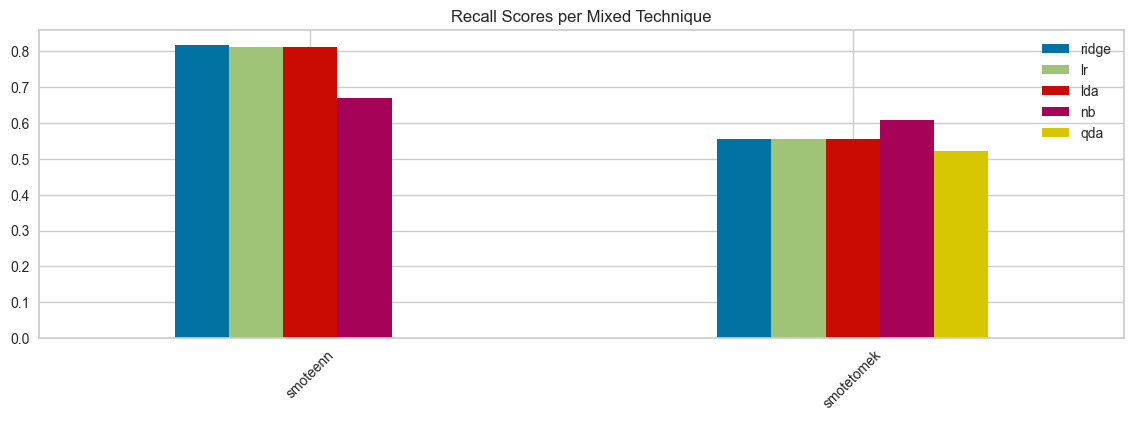

In [23]:
mix_df.plot(kind='bar', rot=45, legend=True, figsize=(14,4))
plt.title('Recall Scores per Mixed Technique')
plt.show()

## Post-Campaign Modeling

In [24]:
post_camp_cat_features = [col for col in X.columns if X[col].dtype == 'category']

post_camp_cat_features

['job_admin',
 'job_blue-collar',
 'job_entrepreneur',
 'job_housemaid',
 'job_management',
 'job_retired',
 'job_self-employed',
 'job_services',
 'job_student',
 'job_technician',
 'job_unemployed',
 'marital_divorced',
 'marital_married',
 'marital_single',
 'education_primary',
 'education_secondary',
 'education_tertiary',
 'contact_cellular',
 'contact_telephone',
 'contact_unknown',
 'month_apr',
 'month_aug',
 'month_dec',
 'month_feb',
 'month_jan',
 'month_jul',
 'month_jun',
 'month_mar',
 'month_may',
 'month_nov',
 'month_oct']

In [25]:
whole_dataset_oversampled_dict = run_pycaret(X,
                                             target_variable,
                                             categorical_features=post_camp_cat_features,
                                             fix_imbalance=True,
                                             methods=overersample_methods)

Type of imbalance technique: randomoversampler


,Description,Value
0,Session id,3046
1,Target,y
2,Target type,Binary
3,Original data shape,"(38335, 40)"
4,Transformed data shape,"(64535, 40)"
5,Transformed train set shape,"(56868, 40)"
6,Transformed test set shape,"(7667, 40)"
7,Numeric features,8
8,Categorical features,31
9,Preprocess,True


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.8697,0.9440,0.8943,0.3473,0.5002,0.4416,0.5074,3.3170
lightgbm,Light Gradient Boosting Machine,0.8880,0.9490,0.8787,0.3832,0.5335,0.4809,0.5347,0.9970
lr,Logistic Regression,0.8654,0.9308,0.8581,0.3348,0.4816,0.4209,0.4829,2.9520
ada,Ada Boost Classifier,0.8689,0.9296,0.8518,0.3408,0.4866,0.4270,0.4863,1.3840
ridge,Ridge Classifier,0.8793,0.9276,0.8227,0.3575,0.4984,0.4417,0.4915,0.4900
lda,Linear Discriminant Analysis,0.8794,0.9276,0.8227,0.3577,0.4985,0.4418,0.4917,0.4280
svm,SVM - Linear Kernel,0.7477,0.7715,0.7054,0.2257,0.3254,0.2421,0.2985,0.6080
nb,Naive Bayes,0.8293,0.8453,0.6871,0.2529,0.3697,0.2945,0.3441,0.4270
qda,Quadratic Discriminant Analysis,0.8047,0.8484,0.6172,0.3011,0.3883,0.3209,0.3408,0.5140
rf,Random Forest Classifier,0.9340,0.9424,0.4249,0.5624,0.4835,0.4490,0.4543,2.6740


Imbalance type dictionary:
{'randomoversampler': {'gbc': 0.8943, 'lightgbm': 0.8787, 'lr': 0.8581, 'ada': 0.8518, 'ridge': 0.8227}}
************************************************************
Type of imbalance technique: smote


,Description,Value
0,Session id,3046
1,Target,y
2,Target type,Binary
3,Original data shape,"(38335, 40)"
4,Transformed data shape,"(64535, 40)"
5,Transformed train set shape,"(56868, 40)"
6,Transformed test set shape,"(7667, 40)"
7,Numeric features,8
8,Categorical features,31
9,Preprocess,True


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.8734,0.9312,0.8456,0.3483,0.4933,0.4350,0.4912,3.3210
ridge,Ridge Classifier,0.8824,0.9301,0.8214,0.3642,0.5045,0.4489,0.4970,0.8140
lda,Linear Discriminant Analysis,0.8824,0.9301,0.8214,0.3641,0.5045,0.4488,0.4969,0.4360
svm,SVM - Linear Kernel,0.6563,0.7937,0.8133,0.1936,0.2974,0.2024,0.2791,1.7970
nb,Naive Bayes,0.7799,0.8194,0.7332,0.2104,0.3269,0.2410,0.3086,0.5440
qda,Quadratic Discriminant Analysis,0.7699,0.8214,0.7009,0.2459,0.3553,0.2767,0.3210,0.4250
knn,K Neighbors Classifier,0.8091,0.7256,0.5166,0.1946,0.2827,0.1978,0.2294,1.7810
gbc,Gradient Boosting Classifier,0.9324,0.9420,0.5099,0.5396,0.5235,0.4873,0.4879,7.8850
lightgbm,Light Gradient Boosting Machine,0.9390,0.9517,0.4749,0.6043,0.5317,0.4996,0.5038,1.3550
dt,Decision Tree Classifier,0.9169,0.7112,0.4705,0.4351,0.4517,0.4068,0.4074,1.0560


Imbalance type dictionary:
{'randomoversampler': {'gbc': 0.8943, 'lightgbm': 0.8787, 'lr': 0.8581, 'ada': 0.8518, 'ridge': 0.8227}, 'smote': {'lr': 0.8456, 'ridge': 0.8214, 'lda': 0.8214, 'svm': 0.8133, 'nb': 0.7332}}
************************************************************
Type of imbalance technique: borderlinesmote


,Description,Value
0,Session id,3046
1,Target,y
2,Target type,Binary
3,Original data shape,"(38335, 40)"
4,Transformed data shape,"(64535, 40)"
5,Transformed train set shape,"(56868, 40)"
6,Transformed test set shape,"(7667, 40)"
7,Numeric features,8
8,Categorical features,31
9,Preprocess,True


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.8818,0.9308,0.8218,0.3629,0.5033,0.4475,0.4960,2.5460
ridge,Ridge Classifier,0.8939,0.9316,0.7932,0.3887,0.5216,0.4697,0.5077,0.7890
lda,Linear Discriminant Analysis,0.8939,0.9316,0.7932,0.3887,0.5215,0.4697,0.5077,0.3450
nb,Naive Bayes,0.7797,0.8252,0.7485,0.2126,0.3311,0.2455,0.3158,0.9930
svm,SVM - Linear Kernel,0.7788,0.8208,0.7456,0.2406,0.3518,0.2711,0.3348,0.8750
qda,Quadratic Discriminant Analysis,0.7586,0.8211,0.7350,0.2369,0.3509,0.2699,0.3224,1.1760
gbc,Gradient Boosting Classifier,0.9317,0.9424,0.5264,0.5323,0.5290,0.4922,0.4924,6.0490
ada,Ada Boost Classifier,0.9219,0.9218,0.4871,0.4661,0.4760,0.4338,0.4341,2.3070
dt,Decision Tree Classifier,0.9157,0.7157,0.4817,0.4303,0.4540,0.4085,0.4096,0.9650
lightgbm,Light Gradient Boosting Machine,0.9391,0.9512,0.4741,0.6057,0.5313,0.4993,0.5039,1.0860


Imbalance type dictionary:
{'randomoversampler': {'gbc': 0.8943, 'lightgbm': 0.8787, 'lr': 0.8581, 'ada': 0.8518, 'ridge': 0.8227}, 'smote': {'lr': 0.8456, 'ridge': 0.8214, 'lda': 0.8214, 'svm': 0.8133, 'nb': 0.7332}, 'borderlinesmote': {'lr': 0.8218, 'ridge': 0.7932, 'lda': 0.7932, 'nb': 0.7485, 'svm': 0.7456}}
************************************************************


In [26]:
whole_oversampled_df = pd.DataFrame(whole_dataset_oversampled_dict).T
whole_oversampled_df.head()

,gbc,lightgbm,lr,ada,ridge,lda,svm,nb
randomoversampler,0.8943,0.8787,0.8581,0.8518,0.8227,NaN,NaN,NaN
smote,NaN,NaN,0.8456,NaN,0.8214,0.8214,0.8133,0.7332
borderlinesmote,NaN,NaN,0.8218,NaN,0.7932,0.7932,0.7456,0.7485


In [27]:
try:
    whole_oversampled_df.drop('dummy', axis=1, inplace=True)
except:
    print("'dummy' column not found")

'dummy' column not found


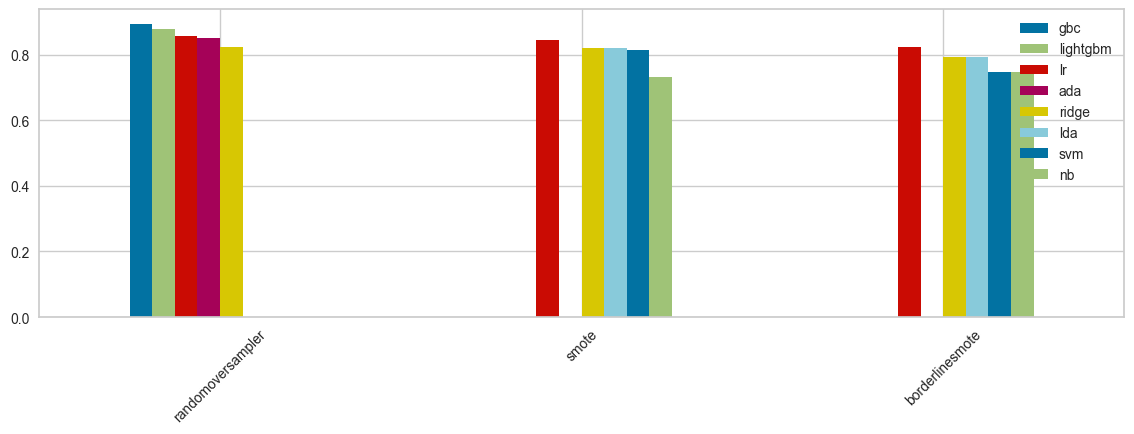

In [28]:
whole_oversampled_df.plot(kind='bar', rot=45, legend=True, figsize=(14,4))
plt.show()

In [29]:
whole_dataset_undersampled_dict = run_pycaret(df_,
                                             target_variable,
                                             categorical_features=post_camp_cat_features,
                                             fix_imbalance=True,
                                             methods=undersample_methods)

Type of imbalance technique: randomundersampler


,Description,Value
0,Session id,3046
1,Target,y_y
2,Target type,Binary
3,Original data shape,"(38335, 41)"
4,Transformed data shape,"(12135, 41)"
5,Transformed train set shape,"(4468, 41)"
6,Transformed test set shape,"(7667, 41)"
7,Numeric features,9
8,Categorical features,31
9,Preprocess,True


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.9999,1.0000,1.0000,0.9982,0.9991,0.9990,0.9990,0.3310
nb,Naive Bayes,0.9998,0.9999,1.0000,0.9969,0.9984,0.9983,0.9983,0.3580
dt,Decision Tree Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.4940
ridge,Ridge Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.3640
rf,Random Forest Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.4060
ada,Ada Boost Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.4900
gbc,Gradient Boosting Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.4390
et,Extra Trees Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.4250
lightgbm,Light Gradient Boosting Machine,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.4300
qda,Quadratic Discriminant Analysis,0.9999,1.0000,0.9996,0.9991,0.9993,0.9993,0.9993,0.3430


Imbalance type dictionary:
{'randomundersampler': {'lr': 1.0, 'nb': 1.0, 'dt': 1.0, 'ridge': 1.0, 'rf': 1.0}}
************************************************************
Type of imbalance technique: tomeklinks


,Description,Value
0,Session id,3046
1,Target,y_y
2,Target type,Binary
3,Original data shape,"(38335, 41)"
4,Transformed data shape,"(37719, 41)"
5,Transformed train set shape,"(30052, 41)"
6,Transformed test set shape,"(7667, 41)"
7,Numeric features,9
8,Categorical features,31
9,Preprocess,True


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,1.0000,1.0000,1.0000,0.9996,0.9998,0.9998,0.9998,3.6570
nb,Naive Bayes,0.9998,0.9999,1.0000,0.9969,0.9984,0.9983,0.9983,2.1080
dt,Decision Tree Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,2.0450
ridge,Ridge Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,2.0800
rf,Random Forest Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,2.3640
ada,Ada Boost Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,2.0430
gbc,Gradient Boosting Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,2.7650
et,Extra Trees Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,2.2820
lightgbm,Light Gradient Boosting Machine,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,2.3510
qda,Quadratic Discriminant Analysis,1.0000,1.0000,0.9996,1.0000,0.9998,0.9998,0.9998,2.0730


Imbalance type dictionary:
{'randomundersampler': {'lr': 1.0, 'nb': 1.0, 'dt': 1.0, 'ridge': 1.0, 'rf': 1.0}, 'tomeklinks': {'lr': 1.0, 'nb': 1.0, 'dt': 1.0, 'ridge': 1.0, 'rf': 1.0}}
************************************************************


In [30]:
whole_undersampled_df = pd.DataFrame(whole_dataset_undersampled_dict).T
whole_undersampled_df.head()

,lr,nb,dt,ridge,rf
randomundersampler,1.0,1.0,1.0,1.0,1.0
tomeklinks,1.0,1.0,1.0,1.0,1.0


In [31]:
try:
    whole_undersampled_df.drop('dummy', axis=1, inplace=True)
except:
    print("'dummy' column not found")

'dummy' column not found


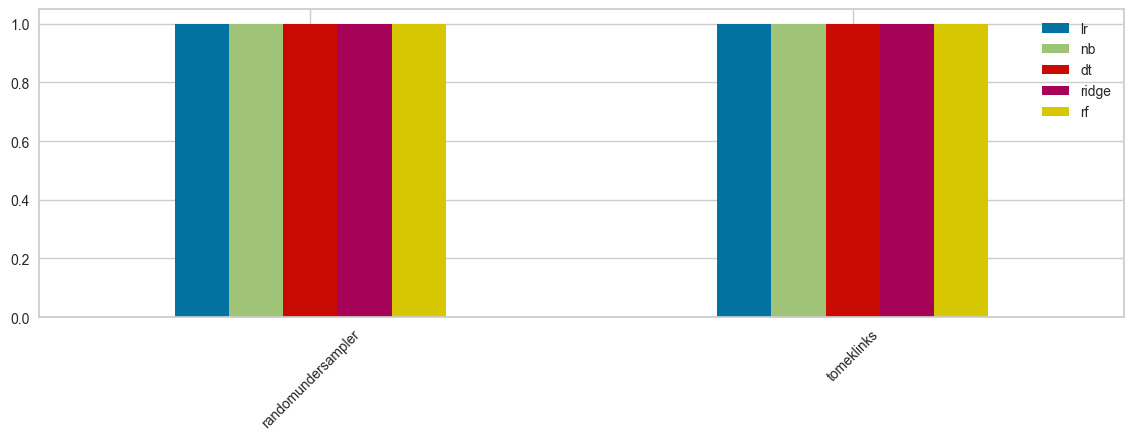

In [32]:
whole_undersampled_df.plot(kind='bar', rot=45, legend=True, figsize=(14,4))
plt.show()

In [33]:
whole_dataset_mixed_dict = run_pycaret(X,
                                             target_variable,
                                             categorical_features=post_camp_cat_features,
                                             fix_imbalance=True,
                                             methods=['smoteenn', 'smotetomek'])

Type of imbalance technique: smoteenn


,Description,Value
0,Session id,3046
1,Target,y
2,Target type,Binary
3,Original data shape,"(38335, 40)"
4,Transformed data shape,"(55608, 40)"
5,Transformed train set shape,"(47941, 40)"
6,Transformed test set shape,"(7667, 40)"
7,Numeric features,8
8,Categorical features,31
9,Preprocess,True


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dummy,Dummy Classifier,0.0728,0.5000,1.0000,0.0728,0.1358,0.0000,0.0000,8.8640
lr,Logistic Regression,0.8474,0.9307,0.8912,0.3100,0.4599,0.3944,0.4696,7.7010
ridge,Ridge Classifier,0.8603,0.9306,0.8729,0.3278,0.4766,0.4146,0.4812,9.8510
lda,Linear Discriminant Analysis,0.8605,0.9305,0.8724,0.3281,0.4768,0.4148,0.4814,8.4760
svm,SVM - Linear Kernel,0.6444,0.8188,0.8537,0.1655,0.2712,0.1696,0.2661,8.6120
nb,Naive Bayes,0.7795,0.8635,0.8232,0.2243,0.3525,0.2687,0.3519,6.4440
qda,Quadratic Discriminant Analysis,0.7581,0.8596,0.8075,0.2485,0.3735,0.2941,0.3581,9.4950
gbc,Gradient Boosting Classifier,0.9120,0.9401,0.7247,0.4378,0.5457,0.5003,0.5199,14.9000
lightgbm,Light Gradient Boosting Machine,0.9235,0.9487,0.7140,0.4835,0.5764,0.5360,0.5485,9.0120
ada,Ada Boost Classifier,0.9073,0.9244,0.6710,0.4167,0.5138,0.4657,0.4820,8.4330


Imbalance type dictionary:
{'smoteenn': {'dummy': 1.0, 'lr': 0.8912, 'ridge': 0.8729, 'lda': 0.8724, 'svm': 0.8537}}
************************************************************
Type of imbalance technique: smotetomek


,Description,Value
0,Session id,3046
1,Target,y
2,Target type,Binary
3,Original data shape,"(38335, 40)"
4,Transformed data shape,"(63997, 40)"
5,Transformed train set shape,"(56330, 40)"
6,Transformed test set shape,"(7667, 40)"
7,Numeric features,8
8,Categorical features,31
9,Preprocess,True


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.8727,0.9315,0.8420,0.3464,0.4908,0.4321,0.4882,9.9940
ridge,Ridge Classifier,0.8825,0.9302,0.8227,0.3647,0.5053,0.4497,0.4979,6.5540
lda,Linear Discriminant Analysis,0.8825,0.9302,0.8227,0.3646,0.5051,0.4496,0.4978,6.6280
svm,SVM - Linear Kernel,0.7027,0.7765,0.7471,0.2000,0.2974,0.2062,0.2755,7.3110
nb,Naive Bayes,0.7829,0.8185,0.7323,0.2128,0.3297,0.2444,0.3114,6.0180
qda,Quadratic Discriminant Analysis,0.7708,0.8216,0.7004,0.2478,0.3568,0.2785,0.3225,6.0560
gbc,Gradient Boosting Classifier,0.9321,0.9417,0.5246,0.5357,0.5294,0.4928,0.4933,12.4290
knn,K Neighbors Classifier,0.8091,0.7242,0.5174,0.1949,0.2831,0.1983,0.2299,6.9300
lightgbm,Light Gradient Boosting Machine,0.9394,0.9517,0.4861,0.6056,0.5391,0.5071,0.5107,6.6640
dt,Decision Tree Classifier,0.9167,0.7140,0.4767,0.4348,0.4545,0.4095,0.4102,7.3050


Imbalance type dictionary:
{'smoteenn': {'dummy': 1.0, 'lr': 0.8912, 'ridge': 0.8729, 'lda': 0.8724, 'svm': 0.8537}, 'smotetomek': {'lr': 0.842, 'ridge': 0.8227, 'lda': 0.8227, 'svm': 0.7471, 'nb': 0.7323}}
************************************************************


In [34]:
whole_mixed_df = pd.DataFrame(whole_dataset_mixed_dict).T
whole_mixed_df.head()

,dummy,lr,ridge,lda,svm,nb
smoteenn,1.0,0.8912,0.8729,0.8724,0.8537,NaN
smotetomek,NaN,0.8420,0.8227,0.8227,0.7471,0.7323


In [35]:
try:
    whole_mixed_df.drop('dummy', axis=1, inplace=True)
except:
    print("'dummy' column not found")

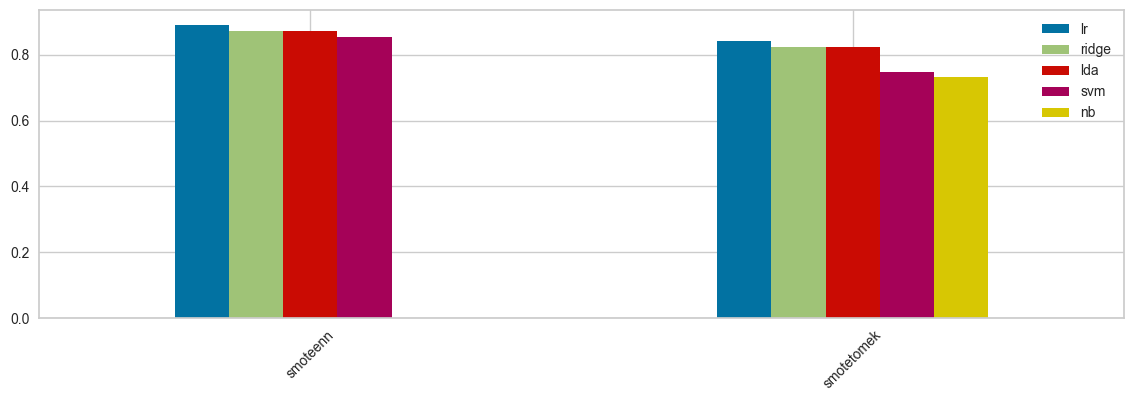

In [36]:
whole_mixed_df.plot(kind='bar', rot=45, legend=True, figsize=(14,4))
plt.show()

Going forward the project will be split into two sections:
* demographic modeling - how well can we predict who will subscribe?
* whole dataset modeling - which customers are more likely to subscribe?

Look at the Demographic Modeling next...